In [1]:
import torch
from torch.autograd import Variable

import argparse
import os
from decoder import OrientationDecoder
from data_loader_utils import data_iterator
from data_generators import get_quadratures, get_orientation_map
from decoder_nonlinear import OrientationDecoder as OrientationDecoderNonlinear
from decoder_upsample import OrientationDecoder as OrientationDecoderUpsample
from decoder_upsample_nonlinear import OrientationDecoder as OrientationDecoderUpsampleNonlinear
from test_decoder import *

#visualize
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from colorspacious import cspace_convert
import numpy as np
from matplotlib import pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
from scipy import stats

# Plot the decoded orientations along the lines of interest.

This is it! Do DNNs see geometric illusions?

In [3]:
### First we select the locations of the trained model and the illusions

ILLUSIONS_LOCATION = "/home/abenjamin/DNN_illusions/data/illusions/"
MODELS_LOCATION = "/home/abenjamin/DNN_illusions/data/models/"

### Now we select which model version we want. Which layer are we reading from?
LAYER = 16

maxpool_indices = [ 4, 9, 16, 23, 30]
assert LAYER in maxpool_indices

model_name = MODELS_LOCATION + "many_white_on_black_lines_layer_{}.pt".format(LAYER)


Now load the model

In [4]:
def load_model(model_path, layer):
    model = OrientationDecoderUpsampleNonlinear(layer)

    model.load_state_dict(torch.load(model_path))
    model.eval().cuda()
    return model

model = load_model(model_name, LAYER)

Now we load all the illusions and pass them through the network.

In [5]:
#a list of tuples of (input_image (3x224x224), orientation_image (2x224x224), target_orientation_image (2x224x224))
input_output_target = pass_test_images(model, ILLUSIONS_LOCATION, 
                                       gpu=  True)


Let's choose an illusion

In [6]:
ILLUSION_NUMBER = 1
original_input, decoded_orient, target_orient = input_output_target[ILLUSION_NUMBER]

In [7]:
# get the orientation of the target
filts = get_quadratures(15)
# note that we invert to get the map
target_orient = get_orientation_map(1-np.mean(check_on_float_scale(original_input),axis=0), filts)

<class 'numpy.ndarray'> (2, 224, 224)


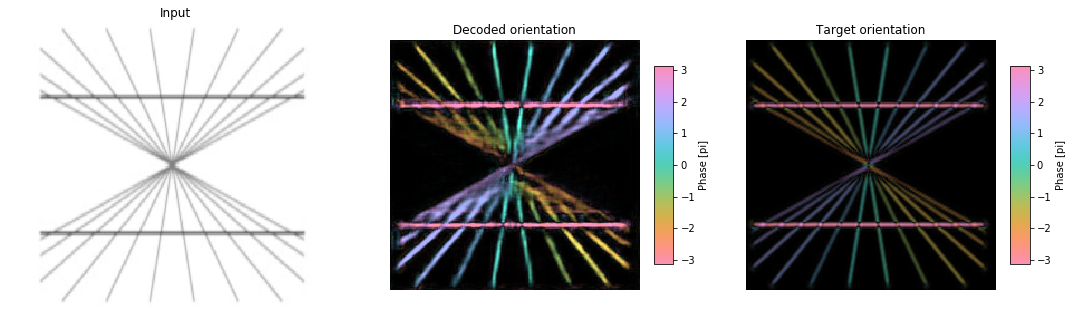

In [8]:
# Let's take a look
save_and_visualize([(original_input, decoded_orient, target_orient)])

In [9]:
THIS_ILLUSION_SLICE_LOC = 57

In [10]:
def give_angle_on_slice(im_slice, axis_to_average_over = 1):
    """
    Returns the angle over a (potentially 2d) slice of an orientation image. 
    
    axis_to_average_over is 0 when you want to collapse vertically
                           and 1 when you want to collapse horizontally
                           
    Maps to the 0 to pi interval which makes more sense given colors

     """
    assert im_slice.shape[0] == 2  #shape  2xn
    angle = -np.arctan2(im_slice[1], im_slice[0])/2+np.pi/2
    # collapse the angle along axis
    if len(angle.shape)>1:
        angle = np.mean(angle, axis = axis_to_average_over)
    return angle

def plot_angle(angle, shift_by_pi = False, regress = False, skip = 10):
    if shift_by_pi:
        angle = angle + np.pi/2
    angle[angle>np.pi/2] = angle[angle>np.pi/2]-2*np.pi/2
    angle[-angle>np.pi/2] = angle[-angle>np.pi/2]+2*np.pi/2
    angle = angle[skip:-skip]
    plt.plot(angle,'.')
    
    if regress:
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(angle)), angle)
        print(p_value)
        xx = np.array([len(angle)])
        plt.plot(xx, intercept+slope*xx, 'k', lw=.5)
    
    plt.ylabel("Decoded Angle")
    plt.xlabel("Pixel #")
    plt.tight_layout()


For the decoded orientation:

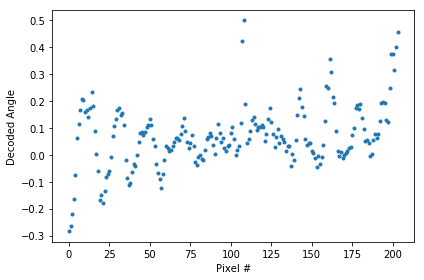

In [11]:
angle_at_slice = give_angle_on_slice(decoded_orient[:,THIS_ILLUSION_SLICE_LOC])
plot_angle(angle_at_slice)

For the actual (target) orientation:

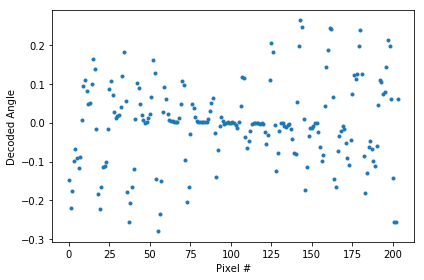

In [12]:
angle_at_slice_target = give_angle_on_slice(target_orient[:,THIS_ILLUSION_SLICE_LOC])
plot_angle(angle_at_slice_target)

The difference:

0.00018552441984125403


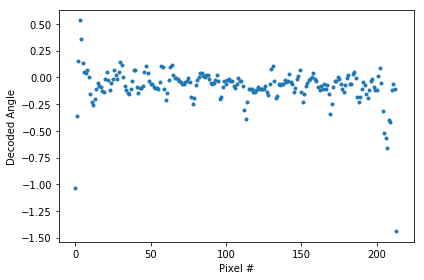

In [13]:
plot_angle(angle_at_slice_target - angle_at_slice, False, True, 5)
# plt.ylim(-.5,.5)

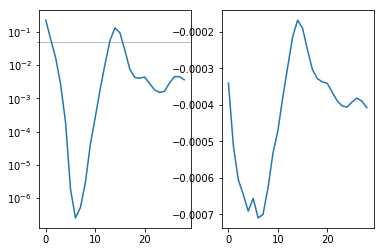

In [14]:
ps = []
slopes = []
for skip in range(1,30):
    angle = angle_at_slice_target - angle_at_slice
    angle[angle>np.pi/2] = angle[angle>np.pi/2]-2*np.pi/2
    angle[-angle>np.pi/2] = angle[-angle>np.pi/2]+2*np.pi/2
    angle = angle[skip:-skip]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(angle)), angle)
    slopes.append(slope)
    ps.append(p_value)
plt.subplot(121)
plt.semilogy(ps)

ax  =plt.gca()
ax.set_yticks([0.05], minor=True)
plt.grid(which='minor', axis='y')
plt.subplot(122)
plt.plot(slopes)


### Let's try taking the difference between the orientation at the top and bottom of the image

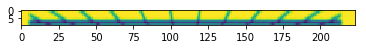

In [15]:
plt.imshow(original_input[0][50:60])

plt.show()

In [16]:
BOTTOM_SLICE_LOC = 165

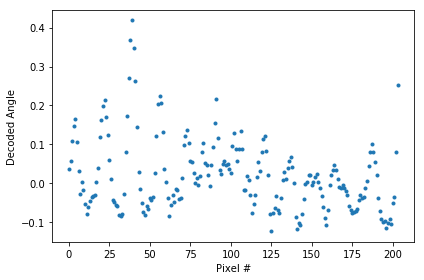

In [17]:
angle_at_slice_bottom = give_angle_on_slice(decoded_orient[:,BOTTOM_SLICE_LOC])
plot_angle(angle_at_slice_bottom)

1.172778716538176e-09


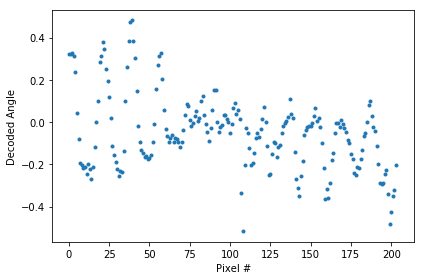

In [18]:
plot_angle(angle_at_slice_bottom - angle_at_slice, False, True)
# plt.ylim(-.5,.5)

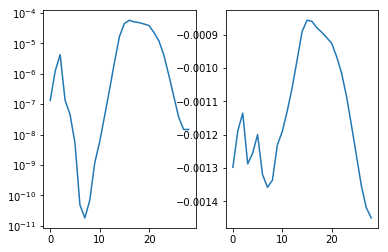

In [20]:
ps = []
slopes = []
for skip in range(1,30):
    angle = angle_at_slice_bottom - angle_at_slice
    angle[angle>np.pi/2] = angle[angle>np.pi/2]-2*np.pi/2
    angle[-angle>np.pi/2] = angle[-angle>np.pi/2]+2*np.pi/2
    angle = angle[skip:-skip]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(angle)), angle)
    ps.append(p_value)
    slopes.append(slope)

plt.subplot(121)
plt.semilogy(ps)

ax  =plt.gca()
ax.set_yticks([0.05], minor=True)
plt.grid(which='minor', axis='y')
plt.subplot(122)
plt.plot(slopes)